In [1]:
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.4.1


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load and explore NER data set

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Data science/ner_dataset.csv', encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
print('Unique words in corpus: ', df['Word'].nunique())
print('Unique tags in corpus: ', df['Tag'].nunique())

Unique words in corpus:  35178
Unique tags in corpus:  17


In [7]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [8]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

In [9]:
num_words, num_tags

(35179, 17)

Retrieve sentences and corresponding tags

In [10]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())]
        self.grouped = self.df.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [11]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [12]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]


Define mappings between sentences and tags

In [13]:
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

Padding input sentences and creating train/test split¶

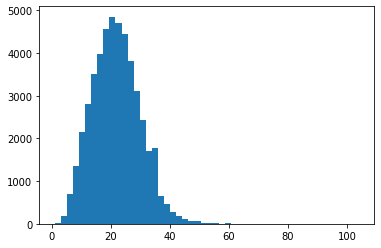

In [14]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [29]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 17)            1717      
Total params: 1,821,067
Trainable params: 1,821,067
Non-trainable params: 0
_________________________________________________________________


In [30]:
history1 = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1080/1080 [==============================] - 119s 108ms/step - loss: 0.4662 - accuracy: 0.9312 - val_loss: 0.1194 - val_accuracy: 0.9675
Epoch 2/3
1080/1080 [==============================] - 119s 110ms/step - loss: 0.0964 - accuracy: 0.9747 - val_loss: 0.0657 - val_accuracy: 0.9815
Epoch 3/3
1080/1080 [==============================] - 119s 110ms/step - loss: 0.0533 - accuracy: 0.9845 - val_loss: 0.0569 - val_accuracy: 0.9829


Build and compile a Bidirectional LSTM model

In [17]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [18]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [20]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
#callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1080/1080 [==============================] - 220s 197ms/step - loss: 0.3883 - accuracy: 0.9345 - val_loss: 0.0668 - val_accuracy: 0.9805
Epoch 2/3
1080/1080 [==============================] - 214s 198ms/step - loss: 0.0559 - accuracy: 0.9837 - val_loss: 0.0498 - val_accuracy: 0.9848
Epoch 3/3
1080/1080 [==============================] - 213s 198ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.0473 - val_accuracy: 0.9855


Evaluate Named Entity Recognition model

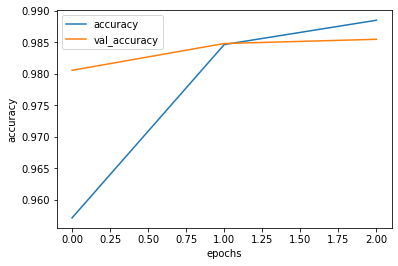

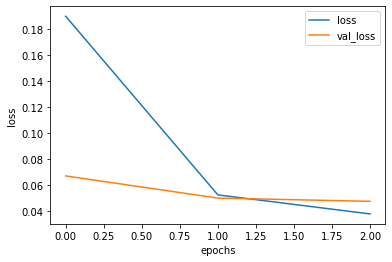

In [25]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

In [33]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 15ms/step - loss: 0.0590 - accuracy: 0.9827


[0.05902648717164993, 0.9827398061752319]

In [44]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(np.array(y_test), axis=-1)[i]


print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Meanwhile      O	O
,              O	O
U.N.           B-org	B-org
Secretary-GeneralI-org	I-org
Kofi           B-per	B-per
Annan          I-per	I-per
is             O	O
expected       O	O
to             O	O
attend         O	O
a              O	O
donors         O	O
meeting        O	O
in             O	O
Islamabad      B-geo	B-geo
on             O	O
November       B-tim	B-tim
19             I-tim	I-tim
to             O	O
raise          O	O
funds          O	O
for            O	O
rebuilding     O	O
earthquake-hit O	O
areas          O	O
.              O	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O
conservative-dominatedO	O